# BiLSTM Implementation for Poem Emotion Analysis
- Ideally to be run in Google Colab

In [ ]:
!pip install nltk datasets textblob tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


## Dataset preprocessing
- Dataset taken from [here](https://huggingface.co/datasets/Ozziey/poems_dataset)

In [ ]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("Ozziey/poems_dataset", download_mode="force_redownload")

df = pd.DataFrame(dataset['train'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

---

## Stop-Word Removal

In natural language processing, stop words are common words that are often removed from text data because they are considered to carry little meaningful information for tasks like text classification. Common stop words include articles, pronouns, prepositions, conjunctions, auxiliary verbs, and adverbs. However, in the context of analyzing historical text, such as Shakespearean poems, there are additional stop words that need to be considered.

### Common Stop Words (Examples):

- Articles: 'a', 'an', 'the'
- Pronouns: 'I', 'you', 'he', 'she', 'it', 'we', 'they'
- Prepositions: 'in', 'at', 'on', 'over', 'under', 'with'
- Conjunctions: 'and', 'but', 'or', 'so', 'yet'
- Auxiliary Verbs: 'is', 'am', 'are', 'was', 'were', 'be', 'being', 'been'
- Common Adverbs: 'very', 'too', 'just', 'also', 'then', 'there'
- Others: 'that', 'what', 'which', 'who', 'whom'

### Additional Shakespearean Stop-Words:

There are certain unusual terms and expressions in Shakespearean English that are not common in contemporary English. Even while these terms had significance in the past, they might not be applicable to tasks involving text classification today. Shakespearean English-specific stop words include the following ones:

- **Common Articles and Prepositions:**
  - 'thee' (you)
  - 'thou' (you)
  - 'thy' (your)
  - 'thine' (yours)
  - 'ye' (you)

- **Pronouns:**
  - 'thou' (you)
  - 'thee' (you)
  - 'thy' (your)
  - 'thine' (yours)
  - 'ye' (you)

- **Auxiliary and Modal Verbs:**
  - 'hast' (have)
  - 'hath' (has)
  - 'dost' (do)
  - 'doth' (does)
  - 'wilt' (will)
  - 'shalt' (shall)

- **Conjunctions and Adverbs:**
  - 'ere' (before)
  - 'whence' (from where)
  - 'whither' (to where)
  - 'wherefore' (why)

- **Common Shakespearean Phrases:**
  - 'good morrow' (good morning)
  - 'prithee' (please)
  - 'perchance' (perhaps)
  - 'verily' (truly)

### Defining the Preprocessing Function
To handle certain Shakespearean stop-words, a data preparation tool has been built. This tool can do the following tasks:

1. Standardising letter case guarantees consistency in word processing.

2. Eliminating stop words: It gets rid of both common and unusual Shakespearean stop words.

3. material segmentation: To enable more in-depth examination, the material is divided into discrete words.

Text data is cleaned and prepared using this preprocessing tool for a variety of analytical and text classification applications.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# define a function to calculate max lengths
def calculate_max_lengths(dataset):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(dataset['poem content'])
    max_sequence_length = max(len(seq) for seq in tokenizer.texts_to_sequences(dataset['poem content']))
    max_words = len(tokenizer.word_index)
    return max_sequence_length, max_words

# dalculate max lengths
max_sequence_length, max_words = calculate_max_lengths(df)

# initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['poem content'])

# convert text to sequences and apply padding
sequences = tokenizer.texts_to_sequences(df['poem content'])
sequences_padded = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    additional_stopwords = ['thou', 'thy', 'thine', 'ye', 'art', 'hast', 'hath', 'dost', 'doth', 'wilt', 'shalt', 'ere', 'whence', 'whither', 'wherefore', 'good', 'morrow', 'prithee', 'perchance', 'verily']
    stop_words.update(additional_stopwords)
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

df['poem content'] = df['poem content'].apply(remove_stopwords)

# convert emotion scores to categorical labels
emotion_threshold = 0.5
emotion_classes = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
df[emotion_classes] = (df[emotion_classes] >= emotion_threshold).astype(int)

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, df[emotion_classes].values, test_size=0.2, random_state=42, stratify=df[emotion_classes].values)

# apply RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Distribution:
- Now we verify the distribution of the `pred` values after the split to ensure that the there is an equal ratio of `pred` values across the training and testing sets.


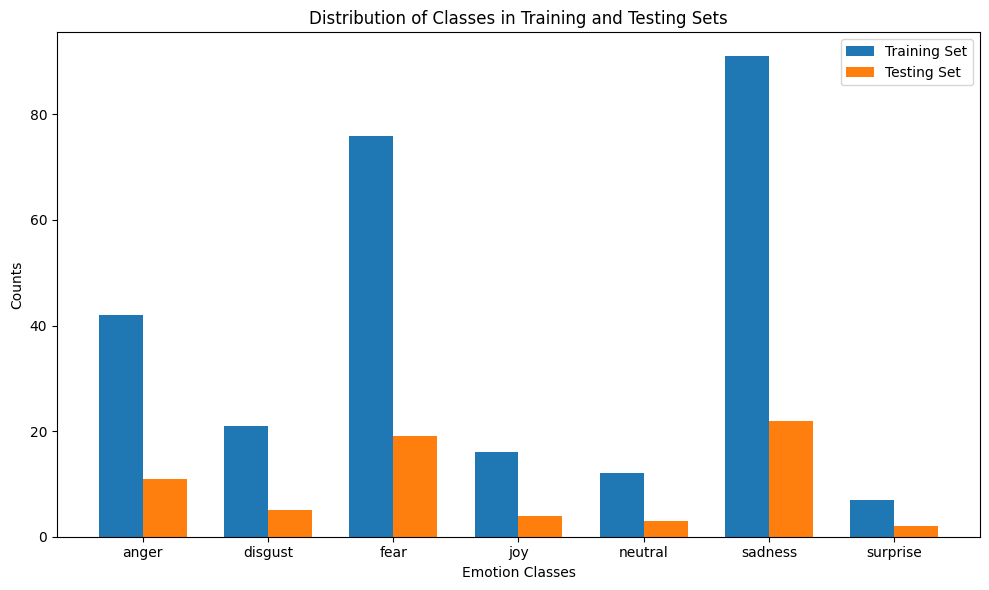

In [ ]:
import matplotlib.pyplot as plt

train_class_counts = y_train.sum(axis=0)
test_class_counts = y_test.sum(axis=0)

emotion_classes = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(emotion_classes))

bar1 = ax.bar(index, train_class_counts, bar_width, label='Training Set')
bar2 = ax.bar([i + bar_width for i in index], test_class_counts, bar_width, label='Testing Set')

ax.set_xlabel('Emotion Classes')
ax.set_ylabel('Counts')
ax.set_title('Distribution of Classes in Training and Testing Sets')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(emotion_classes)
ax.legend()

plt.tight_layout()
plt.show()


C-BiLSTM Model with an embedding layer

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.regularizers import L1L2
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K

precision_metric = Precision()
recall_metric = Recall()

def F1Score(y_true, y_pred):
    p = precision_metric(y_true, y_pred)
    r = recall_metric(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df[emotion_classes].values.argmax(axis=1)),
    y=df[emotion_classes].values.argmax(axis=1)
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# model configuration
embedding_dim = 50
lstm_units = 64
dropout_rate = 0.5
num_filters = 32
kernel_size = 3
pool_size = 2
regularizer = L1L2(l1=1e-5, l2=1e-4)

# build the model
model = Sequential([
    Embedding(input_dim=max_words + 1, output_dim=embedding_dim, input_length=max_sequence_length),
    Conv1D(num_filters, kernel_size, activation='relu'),
    MaxPooling1D(pool_size=pool_size),
    Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizer)),
    Dropout(dropout_rate),
    Bidirectional(LSTM(lstm_units, kernel_regularizer=regularizer)),
    Dense(len(emotion_classes), activation='sigmoid', kernel_regularizer=regularizer)
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', precision_metric, recall_metric, F1Score]
)

# define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=0.001)

# fit the model
history = model.fit(
    X_resampled, y_resampled,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {scores[0]}, Test accuracy: {scores[1]*100}%')


Epoch 1/30
30/30 [==============================] - 29s 283ms/step - loss: 4.5363 - accuracy: 0.1429 - precision: 0.1424 - recall: 0.5474 - F1Score: 0.2232 - val_loss: 2.2505 - val_accuracy: 0.0222 - val_precision: 0.0389 - val_recall: 0.2121 - val_F1Score: 0.0615 - lr: 0.0010
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 7s 232ms/step - loss: 2.6002 - accuracy: 0.3368 - precision: 0.1943 - recall: 0.5725 - F1Score: 0.2528 - val_loss: 2.0845 - val_accuracy: 0.0444 - val_precision: 0.0526 - val_recall: 0.1667 - val_F1Score: 0.0814 - lr: 0.0010
Epoch 3/30
30/30 [==============================] - 6s 200ms/step - loss: 1.1925 - accuracy: 0.5203 - precision: 0.2766 - recall: 0.7372 - F1Score: 0.3911 - val_loss: 1.8218 - val_accuracy: 0.0222 - val_precision: 0.1358 - val_recall: 0.7879 - val_F1Score: 0.2415 - lr: 0.0010
Epoch 4/30
30/30 [==============================] - 6s 215ms/step - loss: 0.7048 - accuracy: 0.6204 - precision: 0.2966 - recall: 0.9958 - F1Score: 0.4538 - val_loss: 1.5460 - val_accuracy: 0.1444 - val_precision: 0.1447 - val_recall: 0.8636 - val_F1Score: 0.2535 - lr: 0.0010
Epoch 5/30
30/30 [==============================] - 5s 177ms/step - loss: 0.4277 - accuracy: 0.7185 - precision: 0.3110 - recall: 0.9990 - F1Score: 0.4602 - val_loss: 1.4148 - val_

- Generate metrics on learning process and its visualisations for training and validation accuracy, loss, and F1 Score.


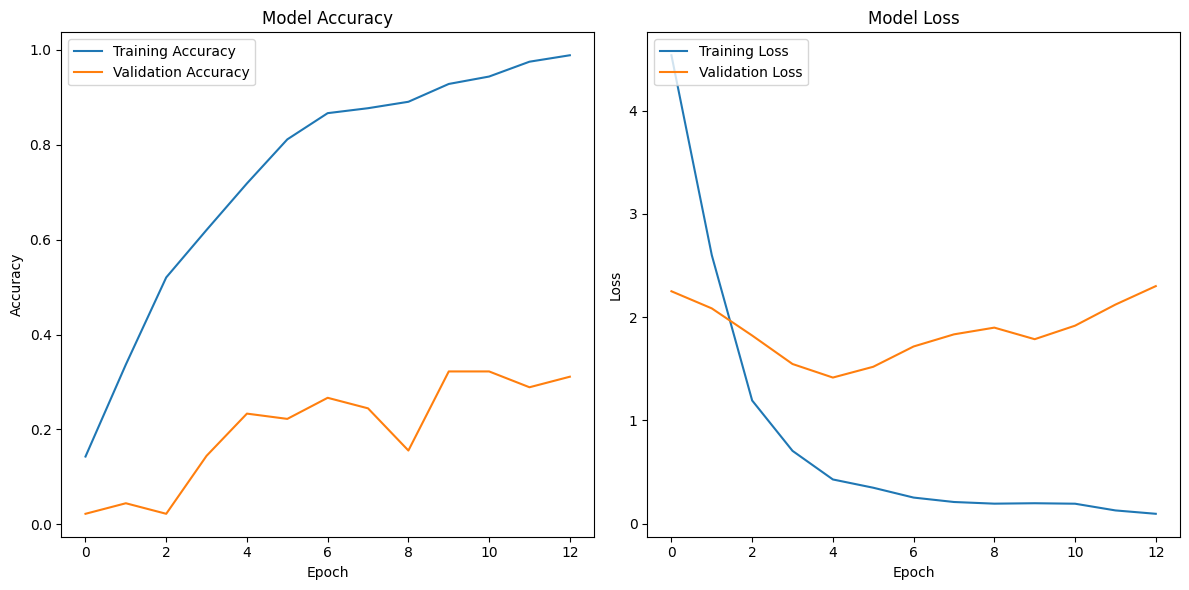

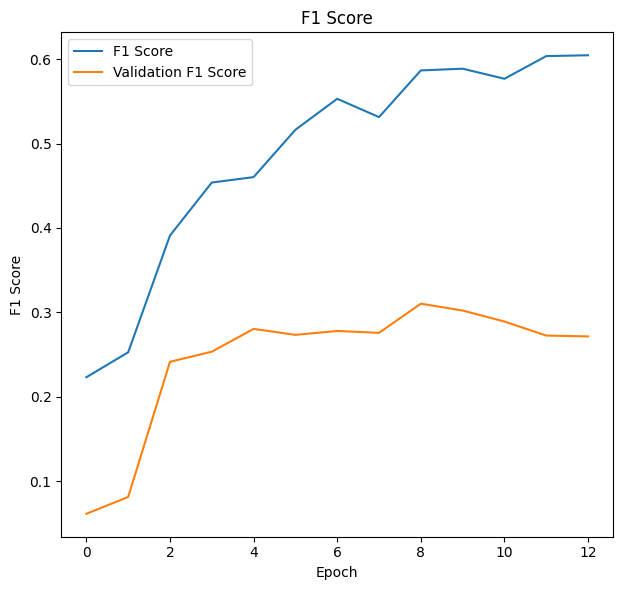

In [ ]:
import matplotlib.pyplot as plt

# plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# plot training & validation loss
plt.subplot(122)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# show plots
plt.tight_layout()
plt.show()

# plot F1 score, precision, and recall
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['F1Score'], label='F1 Score')
plt.plot(history.history['val_F1Score'], label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')

# show plots
plt.tight_layout()
plt.show()
